In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

import mlrfit as mf
import mfmodel as mfm

In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4


nsamples = 40
L = 5


ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=26.191287975202115, noise_var=6.443397937453872
SNR=4.064825458467909, signal_to_noise=4


In [6]:
true_D_noise.min(), true_D_noise.max()

(0.00019840622899317459, 13.071015711881866)

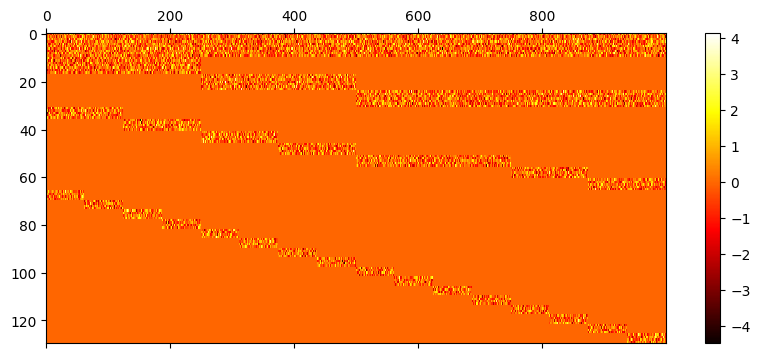

(1000, 130)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [9]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)
F_hpart["pi_inv"] = mf.inv_permutation(F_hpart["pi"] , F_hpart["pi"] )[0]
permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


# Get $N$ samples

In [10]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
del C
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]
print(N, np.diag(unpermuted_A).min(), np.diag(unpermuted_A).max())

40 8.080054712058926 84.7079715945915


# True model loglikelihoods

In [11]:
true_F, true_D = true_mlr.B[:, :-1]+0, true_D_noise+0
true_mfm = mfm.MFModel(F=true_F, D=true_D, hpart=F_hpart, ranks=ranks)
true_mfm.inv_coefficients(det=True)

true_train_obj = mfm.fast_loglikelihood_value(true_mfm, Y[:, true_mfm.pi_inv])
exp_true_obj_test = mfm.fast_exp_true_loglikelihood_value(true_mfm)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_obj_test}")

TR: train ll=-2422.4406107136074, exp ll=-2435.891541556052


/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# MLE-based fitting

In [12]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=3)

t=0, obj=-3061.3413075901735
t=2, obj=-2275.3260965629634


In [13]:
fitted_mfm.inv_coefficients()
obj_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        fitted_mfm, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")

ML: train ll=-2275.3260965629634, exp ll=-4276.40687000139


# Fast linear algebra

### Linear system solve

In [14]:
v = np.random.randn(n, 1)

hat_x = fitted_mfm.solve(v, eps=1e-12, max_iter=20, printing=False)

reldiff = np.linalg.norm(fitted_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

solve reldiff=1.9610999066979663e-14


### $\mathbf{diag}(\Sigma^{-1})$

In [15]:
d = fitted_mfm.diag_inv()
print(d.min(), d.max(), d.sum()/n)

0.07322625436111294 1.8086567887012266 0.334709480513678


### Matrix-vector

In [16]:
v = np.random.randn(n, 1)

Sigma_v = fitted_mfm.matvec(v)